In [118]:
import pygad
import numpy as np
from model.build_rocket import RocketModel
import math

In [119]:

params_list = [11.5 * 1e6, 2.9, 0.23125, 190, 
                11.5 * 1e6, 2.9, 0.23125, 190,
                2,
                2.6]
bounds = [[1e6, 30e6], [1, 9], [0.05, 0.6], [2, 200],
          [1e6, 30e6], [1, 9], [0.05, 0.6], [2, 200],
          [1, 10],
          [1, 10]
 ]

bounds_norm = [[0, 1], [0, 1], [0, 1], [0, 1],
          [0, 1], [0, 1], [0, 1], [0, 1],
          [0, 1],
          [0, 1]
 ]

def normalize(parameters_list, bounds):
    normalized_list = []
    for param, bound in zip(params_list, bounds):
        lower_bound = bound[0]
        upper_bound = bound[1]
        norm_param = (param - lower_bound) / (upper_bound - lower_bound)
        normalized_list.append(norm_param)
    return normalized_list

def denormalize(norm_params_list, bounds):
    denormalized_list = []
    for norm_param, bound in zip(norm_params_list, bounds):
        lower_bound = bound[0]
        upper_bound = bound[1]
        denorm_param = (norm_param * (upper_bound - lower_bound)) + lower_bound
        denormalized_list.append(denorm_param)
    return denormalized_list

def fitness_func(parameters_list, solution_idx):
    parameters_list = denormalize(parameters_list, bounds)
    engineParams = {"oxName": "LOX",
                    "fuelName": "RP-1",
                    "combPressure": parameters_list[0],
                    "MR": parameters_list[1],
                    "nozzleDiam": parameters_list[2],
                    "eps": parameters_list[3]}

    engineParamsFirst = {"oxName": "LOX",
                    "fuelName": "RP-1",
                    "combPressure": parameters_list[4],
                    "MR": parameters_list[5],
                    "nozzleDiam": parameters_list[6],
                    "eps": parameters_list[7]}

    upperStageStructureParams = {"oxName": "LOX",
                                 "fuelName": "RP1",
                                 "MR": parameters_list[1],
                                 "tankPressure": 0.1,
                                 "radius": parameters_list[8],
                                } # 0 porque ainda nao temos esse valor
    firstStageStructureParams = {"oxName": "LOX",
                                "fuelName": "RP1",
                                "MR": parameters_list[5],
                                "tankPressure": 0.1,
                                "radius": parameters_list[9],
                            } # 0 porque ainda nao temos esse valor
    payloadBayParams = {"payloadHeight": 6.7,
                    "payloadRadius": 4.6/2,
                    "payloadMass": 7500,
                    "lowerStageRadius": parameters_list[8],
                    "lowerRocketSurfaceArea": 0} # 0 porque ainda nao temos esse valor

    rocket_model = RocketModel(upperEngineParams=engineParams,
                               firstEngineParams=engineParamsFirst,
                               payloadBayParams=payloadBayParams,
                               upperStageStructureParams=upperStageStructureParams,
                               firstStageStructureParams = firstStageStructureParams,
                               deltaV_upperStage=8500,
                               deltaV_landing=2000,
                               deltaV_firstStage=3500,
                               nEnginesUpperStage=1,
                               nEnignesFirstStage=10)
    try:
        rocket_model.build_all()
        glow = rocket_model.glow
    except:
        glow = 1e19

    #print(rocket_model.upperStageEngine.thrustVac)
    #print(rocket_model.m_0_2)

    if math.isnan(glow):
        glow = 1e19
    if math.isnan(rocket_model.m_0_1):
        glow = 1e19
    if math.isnan(rocket_model.m_0_2):
        glow = 1e19
    if rocket_model.m_0_1 <= 0:
        glow = 1e19
    if rocket_model.m_0_2 <= 0:
        glow = 1e19
    if rocket_model.m_p_1 <= 0:
        glow = 1e19
    if rocket_model.m_p_2 <= 0:
        glow = 1e19
    if rocket_model.upperStageStructure.oxTankCylHeight < 0:
        glow = 1e19
    if rocket_model.upperStageStructure.fuelTankCylHeight < 0:
        glow = 1e19
    if rocket_model.firstStageStructure.oxTankCylHeight < 0:
        glow = 1e19
    if rocket_model.firstStageStructure.fuelTankCylHeight  < 0:
        glow = 1e19
    if rocket_model.upperStageEngine.thrustVac * 1<= 0.8 * rocket_model.m_0_2 * 9.81:
        glow = 1e19
    if rocket_model.firstStageEngine.thrustSea * 10 <= 1.3 * rocket_model.glow * 9.81: # Multiplicar pelo número de motores (9)
        glow = 1e19

    #print(rocket_model.glow * 9.81 * 1.3)
    #print(rocket_model.firstStageEngine.thrustSea * 10)

    #print(0.8 * rocket_model.m_0_2 * 9.81)
    #print(rocket_model.upperStageEngine.thrustVac * 1)

    #glow = glow / 100000
    fitness = 1.0/glow 
    return fitness

norm = normalize(params_list, bounds)
fitness_func(norm, 0)
norm = normalize(params_list, bounds)
denorm = denormalize(norm, bounds)


In [120]:
num_generations = 100
num_parents_mating = 30

fitness_function = fitness_func

sol_per_pop = 200
num_genes = len(params_list)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = -1

crossover_type = "scattered"

mutation_type = "random"
mutation_percent_genes = 10


In [121]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space={'low': 0, 'high': 1},
                       init_range_high=init_range_high,
                       init_range_low=init_range_low,
                       gene_type=float)


In [122]:
ga_instance.run()


reading cea isp data files for LOX / RP_1 233400 times
reading cea isp data files for LOX / RP_1 233500 times
reading cea isp data files for LOX / RP_1 233600 times
reading cea isp data files for LOX / RP_1 233700 times
reading cea isp data files for LOX / RP_1 233800 times
reading cea isp data files for LOX / RP_1 233900 times
reading cea isp data files for LOX / RP_1 234000 times
reading cea isp data files for LOX / RP_1 234100 times
reading cea isp data files for LOX / RP_1 234200 times
reading cea isp data files for LOX / RP_1 234300 times
reading cea isp data files for LOX / RP_1 234400 times
reading cea isp data files for LOX / RP_1 234500 times
reading cea isp data files for LOX / RP_1 234600 times
reading cea isp data files for LOX / RP_1 234700 times
reading cea isp data files for LOX / RP_1 234800 times
reading cea isp data files for LOX / RP_1 234900 times
reading cea isp data files for LOX / RP_1 235000 times
reading cea isp data files for LOX / RP_1 235100 times
reading ce

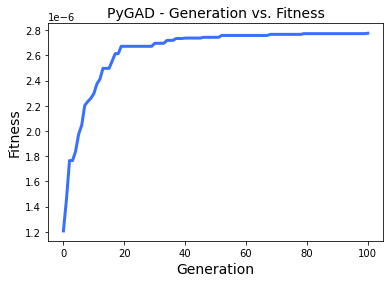

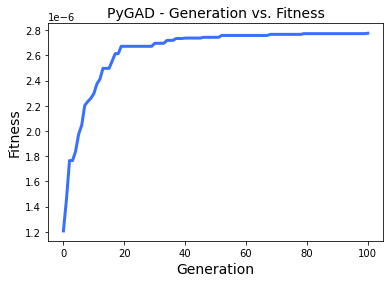

In [123]:
ga_instance.plot_fitness()


In [124]:
best_solution = ga_instance.best_solution()[0]
denormalize(best_solution, bounds)

reading cea isp data files for LOX / RP_1 273600 times
reading cea isp data files for LOX / RP_1 273700 times
reading cea isp data files for LOX / RP_1 273800 times
reading cea isp data files for LOX / RP_1 273900 times


[10963102.1209957,
 3.402300288296038,
 0.1903702730950565,
 199.76494563363832,
 28486974.34525185,
 3.3852176217980112,
 0.09872518765164662,
 31.452782312295593,
 1.867069928646227,
 3.6162282267953563]

In [125]:
fitness_func(ga_instance.best_solution()[0], 0)

reading cea isp data files for LOX / RP_1 274000 times
reading cea isp data files for LOX / RP_1 274100 times
reading cea isp data files for LOX / RP_1 274200 times
reading cea isp data files for LOX / RP_1 274300 times


2.7760035837793725e-06

In [126]:
def rocket_func(parameters_list):
    parameters_list = denormalize(parameters_list, bounds)
    engineParams = {"oxName": "LOX",
                    "fuelName": "RP-1",
                    "combPressure": parameters_list[0],
                    "MR": parameters_list[1],
                    "nozzleDiam": parameters_list[2],
                    "eps": parameters_list[3]}

    engineParamsFirst = {"oxName": "LOX",
                    "fuelName": "RP-1",
                    "combPressure": parameters_list[4],
                    "MR": parameters_list[5],
                    "nozzleDiam": parameters_list[6],
                    "eps": parameters_list[7]}

    upperStageStructureParams = {"oxName": "LOX",
                                 "fuelName": "RP1",
                                 "MR": parameters_list[1],
                                 "tankPressure": 0.1,
                                 "radius": parameters_list[8],
                                } # 0 porque ainda nao temos esse valor
    firstStageStructureParams = {"oxName": "LOX",
                                "fuelName": "RP1",
                                "MR": parameters_list[5],
                                "tankPressure": 0.1,
                                "radius": parameters_list[9],
                            } # 0 porque ainda nao temos esse valor
    payloadBayParams = {"payloadHeight": 6.7,
                    "payloadRadius": 4.6/2,
                    "payloadMass": 7500,
                    "lowerStageRadius": parameters_list[8],
                    "lowerRocketSurfaceArea": 0} # 0 porque ainda nao temos esse valor

    rocket_model = RocketModel(upperEngineParams=engineParams,
                               firstEngineParams=engineParamsFirst,
                               payloadBayParams=payloadBayParams,
                               upperStageStructureParams=upperStageStructureParams,
                               firstStageStructureParams = firstStageStructureParams,
                               deltaV_upperStage=8500,
                               deltaV_landing=2000,
                               deltaV_firstStage=2500,
                               nEnginesUpperStage=1,
                               nEnignesFirstStage=10)
    try:
        rocket_model.build_all()
        glow = rocket_model.glow
    except:
        glow = 1e19
    if math.isnan(glow):
        glow = 1e19
    if math.isnan(rocket_model.m_0_1):
        glow = 1e19
    if math.isnan(rocket_model.m_0_2):
        glow = 1e19
    if rocket_model.m_0_1 <= 0:
        glow = 1e19
    if rocket_model.m_0_2 <= 0:
        glow = 1e19
    if rocket_model.m_p_1 <= 0:
        glow = 1e19
    if rocket_model.m_p_2 <= 0:
        glow = 1e19
    if rocket_model.upperStageStructure.oxTankCylHeight <=0:
        glow = 1e19
    if rocket_model.upperStageStructure.fuelTankCylHeight <= 0:
        glow = 1e19
    if rocket_model.firstStageStructure.oxTankCylHeight <=0:
        glow = 1e19
    if rocket_model.firstStageStructure.fuelTankCylHeight <=0:
        glow = 1e19
    if rocket_model.upperStageEngine.thrustVac * 1<= 0.8 * rocket_model.m_0_2 * 9.81:
        glow = 1e19
    if rocket_model.firstStageEngine.thrustSea * 10 <= 1.3 * rocket_model.glow * 9.81: # Multiplicar pelo número de motores (9)
        glow = 1e19

    #print(rocket_model.upperStageEngine.thrustVac)
    #print(rocket_model.m_0_2)

    if math.isnan(glow):
        glow = 1e19
    #glow = glow / 100000
    fitness = 1.0/glow 
    print(fitness)
    return rocket_model

rocket_model = rocket_func(ga_instance.best_solution()[0])

reading cea isp data files for LOX / RP_1 274400 times
reading cea isp data files for LOX / RP_1 274500 times
reading cea isp data files for LOX / RP_1 274600 times
reading cea isp data files for LOX / RP_1 274700 times
0.0


In [127]:
rocket_model.print_all_parameters()

***** Payload Bay *****
Cone Area: 37.653733282525664 [kg]
Cylinder Area: 96.82388558363742 [kg]
Frustrum Area: 39.39263488216385 [kg]
Total Payload Fairing Mass: 1611.1974969730823 [kg]
Electronic Mass: 414.8902905454325 [kg]
Power Mass: 96.44954584309669 [kg]
Total Payload Mass: 9622.537333361612 [kg]
***** Upper Stage Engine *****
Isp Vac (s): 392.8777309246689
Isp Sea (s): (222.340034297917, 'Separated (Psep=3.77923e+06, epsSep=99.5484)')
Mass flow (kg/s): 179.35581691111722
Thrust Vac (kN): 876.9625520718212
Thrust Sea (kN): 308.3618015135997
***** Upper Stage Structure *****
Ox Tank Cylyndrical Height: 3.8412258654823206 [m]
Fuel Tank Cylyndrical Height: 0.09739710752520582 [m]
Ox Tank Volume: 69.3297304625739 [m3]
Fuel Tank Volume: 28.32943210947636 [m3]
Intertank Structure Mass: 848.301785671616 [kg]
Separation Explosives Mass: 8.371607480024602 [kg]
Tank Fairing Mass: 612.5979853733054 [kg]
Total Stage Height: 15.567603669391236 [m]
Total Stage Dry Mass: 2901.5855668777576 [kg

In [128]:
rocket_model.firstStageStructure.fuelTankCylHeight

-3.8263183633770983

In [129]:
rocket_model.glow

263518.79198372015

In [130]:
1/1e19

0.0

In [131]:
ga_instance.best_solution()

reading cea isp data files for LOX / RP_1 274800 times
reading cea isp data files for LOX / RP_1 274900 times
reading cea isp data files for LOX / RP_1 275000 times
reading cea isp data files for LOX / RP_1 275100 times


(array([0.34355525, 0.30028754, 0.25521868, 0.99881286, 0.9478267 ,
        0.2981522 , 0.08859125, 0.14875143, 0.0963411 , 0.29069203]),
 2.7760035837793725e-06,
 91)